# Prepare data for training NN


In [11]:
import scipy.cluster.hierarchy
from sklearn.model_selection import train_test_split
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


plt.style.use('dark_background')



First, prepare data using old code in `train_models.py`:

In [12]:
# Paths:
input_dir = Path.cwd() / "../input_data"
plots_dir = Path.cwd() / "../plots"
plots_dir.mkdir(exist_ok=True)
result_dir = Path.cwd() / "../results/multioutput"
result_dir.mkdir(exist_ok=True, parents=True)

# ## Loading data
# Loading fingerprints, and molecule properties

# Load fingerprints:
fingerprints = pd.read_csv(input_dir / "fingerprints.csv", index_col=0)
fingerprints.sort_index(inplace=True)
# There seems to be some duplicates in the rows:
fingerprints.drop_duplicates(inplace=True)
# Save columns names:
fingerprints_cols = fingerprints.columns

# Load properties:
mol_properties = pd.read_csv(input_dir / "physchem_properties.csv", index_col=0)
mol_properties.sort_index(inplace=True)
mol_properties.drop_duplicates(inplace=True)
# mol_properties.set_index("name_short", inplace=True)
mol_properties_cols = mol_properties.columns

# Check statistics of molecular properties and handle NaN values:
# Check for NaN values:
is_null = mol_properties.isnull()

# TODO: temporarely set NaN to zero
mol_properties[is_null] = 0.

# Perform some basic checks:
assert fingerprints.index.is_unique
assert mol_properties.index.is_unique

print("Number of fingerprints: ", len(fingerprints))
print("Number of mol properties: ", len(mol_properties))
print("Molecules with missing fingerprints: ")
missing_molecules = list(mol_properties[~ mol_properties.index.isin(fingerprints.index)].index)
print(missing_molecules)

# Merge fingerprints and properties:
all_mol_features = pd.merge(mol_properties, fingerprints, how="inner", right_index=True, left_index=True)

# ### Loading intensities
# Intensities:
intensities = pd.read_csv(input_dir / "3june22_ions_no_nl.csv", index_col=0)
intensities = intensities.rename(columns={"Matrix short": "matrix", "Polarity": "polarity"})
nb_before = len(intensities.name_short.unique())

# Delete molecules with missing properties:
intensities = intensities[~intensities.name_short.isin(missing_molecules)]
print("{}/{} molecules kept".format(len(intensities.name_short.unique()), nb_before))

# #### Remove molecule-adduct combinations that were never observed in any matrix

remove_not_detected_adducts = False

if remove_not_detected_adducts:
    g = intensities.groupby(["name_short", "adduct"], as_index=False)["detected"].max()
    nb_comb_before = intensities.shape[0]
    intensities = intensities.merge(g[g["detected"] == 1][["name_short", "adduct"]])
    print("{}/{} combinations of molecules/adduct with non-zero observed values".format(intensities.shape[0],
                                                                                        nb_comb_before))

    # Now check if some molecules are never observed (for any adduct) and
    # remove them from the feature vectors:
    nb_mol_before = len(all_mol_features.index)
    all_mol_features = all_mol_features[all_mol_features.index.isin(intensities["name_short"].unique())]
    print("{}/{} molecules with non-zero observed values".format(len(all_mol_features.index), nb_mol_before))

# #### How many molecules-adduct observed per matrix-polarity

g = intensities.groupby(['matrix', 'polarity'], as_index=False)
detected_ratio = g["detected"].apply(lambda x: x.sum() / x.shape[0])
detected_ratio["Sum detected"] = g["detected"].sum()["detected"]

# Show values:
detected_ratio.sort_values("detected", ascending=False).rename(columns={"detected": "Ratio detected molecules"})

# Convert adducts to one-hot encoding:
adducts_one_hot = pd.get_dummies(intensities.adduct, prefix='adduct')
adducts_columns = adducts_one_hot.columns
intensities = intensities.merge(right=adducts_one_hot, right_index=True, left_index=True)


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

ss = StandardScaler()
pt = PowerTransformer()

# OPTION 1
features_norm_df = pd.DataFrame(pt.fit_transform(all_mol_features),
                                index=all_mol_features.index,
                                columns=all_mol_features.columns)

# OPTION 2
# features_norm_df = pd.DataFrame(ss.fit_transform(all_mol_features), index = all_mol_features.index, columns = all_mol_features.columns)

# OPTION 3 (Seurat normalization)
# features_norm_df = np.log2((all_mol_features.T / all_mol_features.T.sum().values) * 10000 + 1).T


# V1 normalization:
intensities["norm_intensity"] = pt.fit_transform(intensities[["spot_intensity"]])

# V2:
numpy_intensities = intensities[["spot_intensity"]].to_numpy()
intensities["norm_intensity_seurat"] = np.log2((numpy_intensities.T / numpy_intensities.T.sum()) * 10000 + 1).T



Number of fingerprints:  169
Number of mol properties:  172
Molecules with missing fingerprints: 
['Adenosine triphosphate', 'Ribose 5-phosphate', 'Spermine']
169/172 molecules kept


### Train-Valid split using hierarchical clustering:

In [13]:
# Discretize the intensity:

intensities["detected"] = (intensities["spot_intensity"] > 100).astype("int")

0    20820
1     2344
2      341
3      121
4       34
Name: digitized, dtype: int64

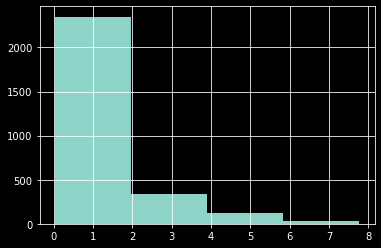

In [14]:
# Recompute Seurat, taking care of setting noisy predictions (<100) to zero:
intensities["norm_intensity_seurat"] = intensities["spot_intensity"]
intensities.loc[intensities["spot_intensity"] < 100, "norm_intensity_seurat"] = 0
numpy_intensities = intensities[["norm_intensity_seurat"]].to_numpy()
intensities["norm_intensity_seurat"] = np.log2((numpy_intensities.T / numpy_intensities.T.sum()) * 10000 + 1).T

# Now digitize them:
zero_mask = intensities["norm_intensity_seurat"] == 0
intensities.loc[~zero_mask,"norm_intensity_seurat"].hist(bins=4)
_, bins = np.histogram(intensities["norm_intensity_seurat"], bins=4)
bins[-1] += 0.1 # Make sure to include the last point in the last bin
intensities["digitized"] = np.digitize(intensities["norm_intensity_seurat"], bins=bins)
# Add the original zero mask:
intensities.loc[zero_mask, "digitized"] = 0
intensities["digitized"].value_counts()



#### Use hierarchical clustering to get decent train-test split
First, we compute the Y digitized matrix:

In [15]:
# features_normalized = features_norm_df
features_normalized = features_norm_df[mol_properties_cols]
intensity_column = "digitized"
test_split_col_name = 'combined'

In [16]:
sorted_intensities = intensities.sort_values(by=['name_short', 'adduct', "matrix", "polarity"])
sorted_intensities = pd.merge(sorted_intensities,
                              features_normalized,
                              how="left",
                              right_index=True,
                              left_on="name_short"
                              ).reset_index(drop=True)


matrix_names = sorted_intensities[["matrix", "polarity"]].drop_duplicates()
out_multi_index = pd.MultiIndex.from_arrays([matrix_names["matrix"], matrix_names["polarity"]])

In [36]:
g = sorted_intensities.groupby(by=['name_short', 'adduct'])
Y = np.array([rows.to_numpy() for _, rows in g[intensity_column]])
X = np.array([rows.iloc[0].to_numpy() for _, rows in
                    g[adducts_columns.tolist() + features_normalized.columns.tolist()]])

mol_names = pd.DataFrame([[name, adduct] for (name, adduct), _ in g],
                              columns=["name_short", "adduct"])
mol_names_index = pd.MultiIndex.from_arrays([mol_names["name_short"], mol_names["adduct"]])

#### Visualize Heatmap and dendrogram
Now cluster rows according to their similarity:

/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


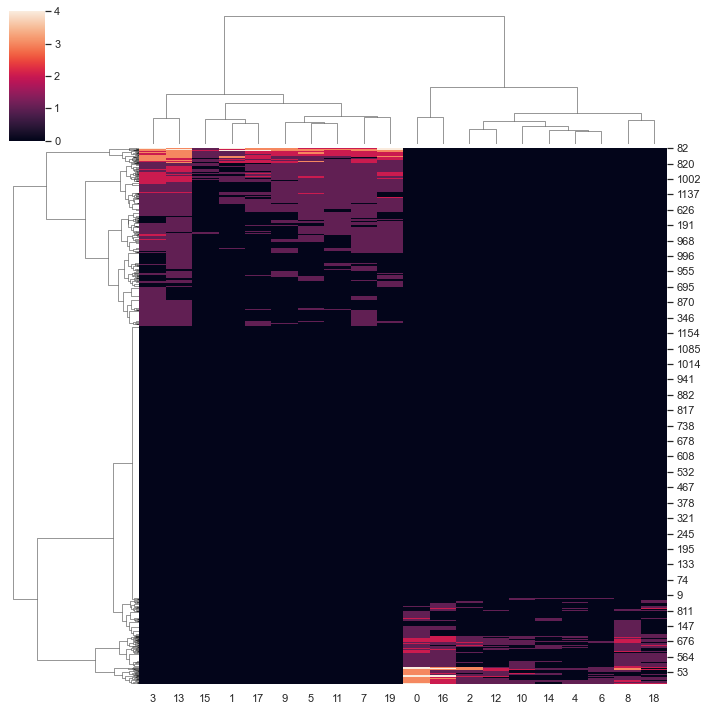

In [18]:
import seaborn as sns
sns.set_theme(color_codes=True)
# species = iris.pop("species")

# Exclude zero rows:
Y_filtered = Y[Y.sum(axis=1) != 0]
g = sns.clustermap(Y, method='ward')


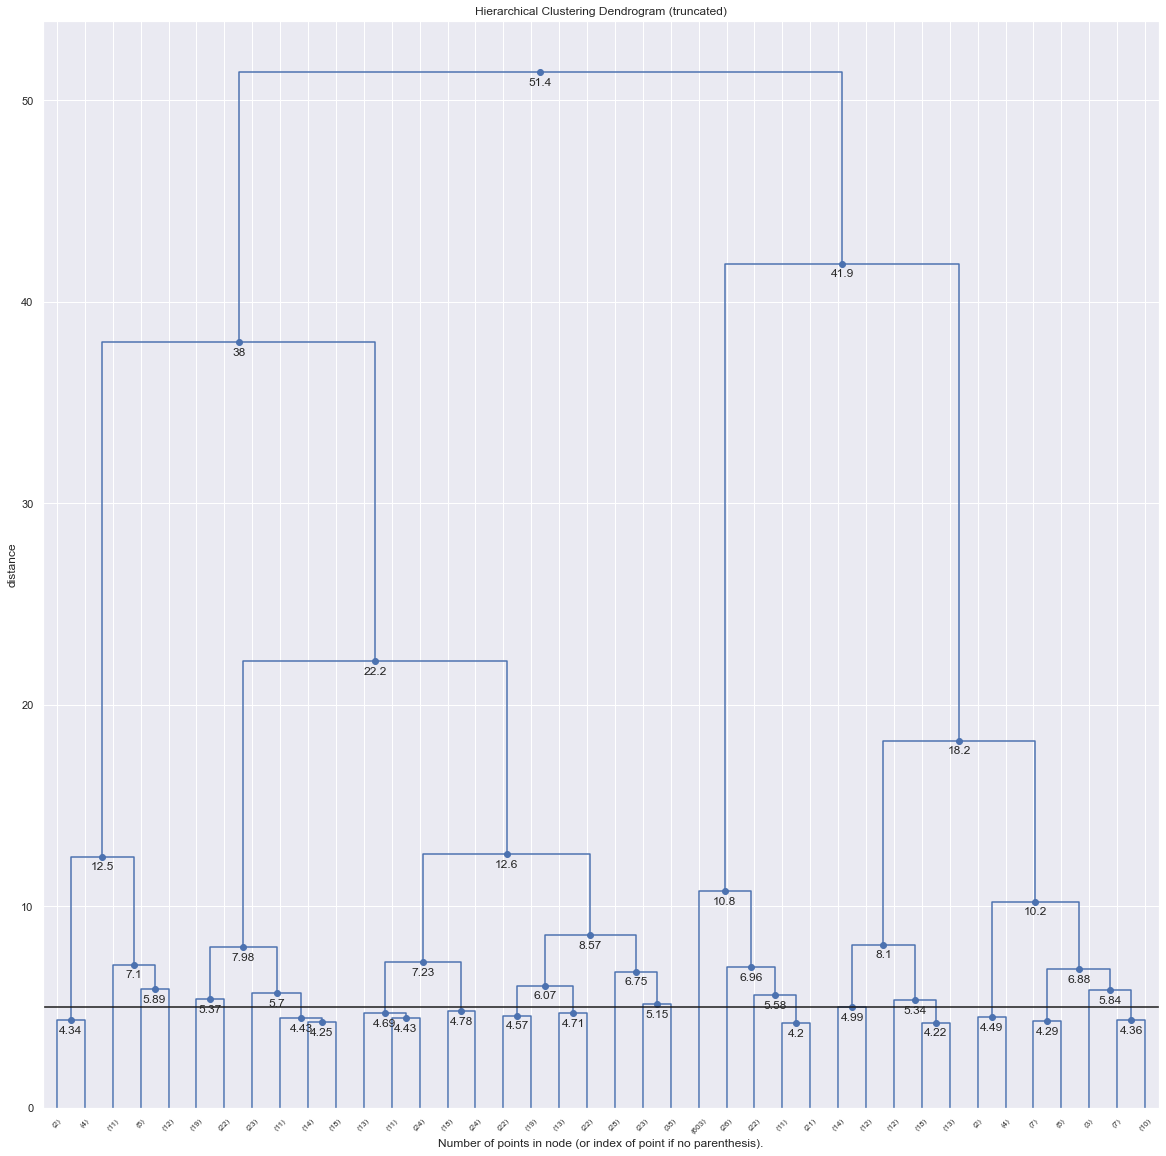

In [19]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


# iris = load_iris()
# X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
import scipy.cluster.hierarchy
Z_clust = scipy.cluster.hierarchy.linkage(Y, method="ward")

out_clustering = scipy.cluster.hierarchy.fcluster(Z_clust, t=5, criterion="distance")


# Z_clust = hier_clust.fit(Y_filtered)
# plot the top three levels of the dendrogram
fig, ax = plt.subplots(1,1,figsize=(20,20))
plt.title("Hierarchical Clustering Dendrogram")
fancy_dendrogram(Z_clust, truncate_mode="lastp", p=40, ax=ax,
                color_threshold=3, max_d=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
fig.savefig(plots_dir / "dendrogram.pdf")

In [20]:
np.unique(out_clustering, return_counts=True)




(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int32),
 array([  6,  11,   5,  12,  19,  22,  23,  43,  48,  42,  41,  35,  28,
         23,  35, 603,  26,  22,  32,  26,  12,  31,   6,  12,   3,  17]))

#### Finally, save results

Save results that will be used for training:

In [21]:
# For the moment, riconvert Y to binary:

# Save data:
out_dir = input_dir / "numpy"
out_dir.mkdir(exist_ok=True)
# np.save(out_dir / "train_indices", np.array(train_index))
# np.save(out_dir / "test_indices", np.array(test_index))
np.save(out_dir / "X", X)
np.save(out_dir / "Y", (Y > 0).astype('int'))
np.save(out_dir / "stratification_classes", out_clustering.astype('int'))






In [38]:
# Save clustering as csv:
pd.DataFrame(out_clustering, columns=["Stratification class"], index=mol_names_index).to_csv(out_dir / "stratification_classes.csv")

# Show results NN training
First, bring back predictions in the original form (one dataframe row per matrix prediction):

In [22]:
nn_results = pd.read_csv("/Users/alberto-mac/EMBL_repos/spotting-project-regression/results/nn_results.csv",
                         index_col=0)
nn_results.sort_index(inplace=True)

Visualize predictions:

/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


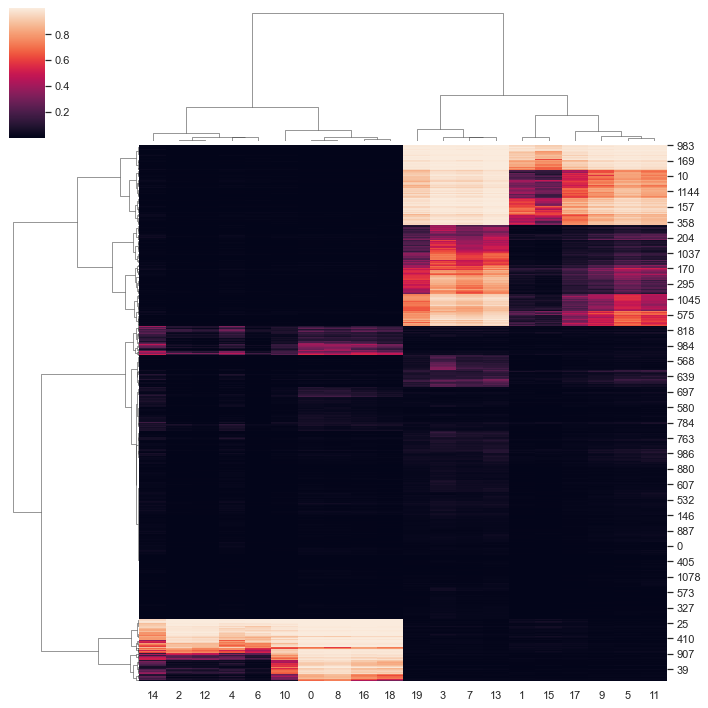

In [23]:
sns.clustermap(nn_results.drop(columns="fold").to_numpy(), method='ward')

Visualize difference between GT and predictions:

/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


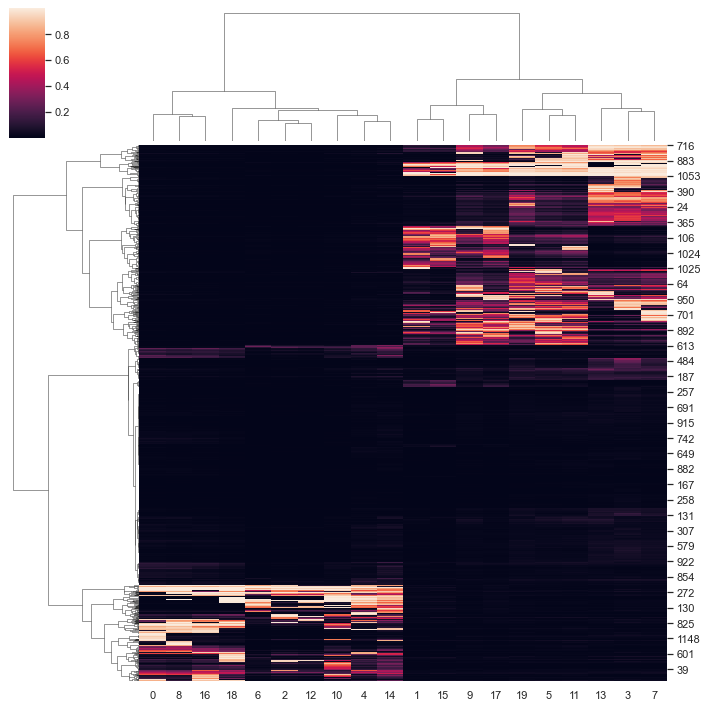

In [27]:
sns.clustermap(np.abs((Y>0) - nn_results.drop(columns="fold").to_numpy()), method='ward')


In [28]:
# Reshape results:
results = pd.DataFrame(Y, columns=out_multi_index).stack(
                    [i for i in range(len(out_multi_index.levels))]).reset_index().drop(columns=["level_0"]).rename(
                    columns={0: "observed_value"})
results['prediction'] = pd.DataFrame(nn_results.drop(columns="fold").to_numpy(), columns=out_multi_index).stack(
    [i for i in range(len(out_multi_index.levels))]).reset_index()[0]
results['regressor'] = "NeuralNet"
results['fold'] = nn_results["fold"]
results.reset_index(drop=True, inplace=True)

In [29]:
# Binarize prediction:
results["prediction"] = (results["prediction"] > 0.5).astype('int')


## Evaluation of classification

In [30]:
detection_results = results.copy()

In [31]:
from sklearn.metrics import classification_report

score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected']

detection_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'classifier'] + score_cols)

counter = 0
for (matrix, polarity, classifier), rows in detection_results.groupby(['matrix', 'polarity', 'regressor']):
    clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
    if rows.observed_value.max() == 0:
        print("no detection!")
    detection_metrics.loc[counter] = [matrix, polarity, classifier,
                                      clf_report['0']['precision'], clf_report['0']['recall'],
                                      clf_report['0']['f1-score'], clf_report['0']['support'],
                                      clf_report['1']['precision'], clf_report['1']['recall'],
                                      clf_report['1']['f1-score'], clf_report['1']['support'],]
    counter += 1

In [34]:
best_det_f1 = detection_metrics.loc[detection_metrics.groupby(['matrix', 'polarity'])["det_f1"].idxmax()].sort_values("det_f1", ascending=False)

# best_det_f1["det_f1"].mean()
# best_det_f1[["matrix", "polarity", "det_f1"]]
best_det_f1

,matrix,polarity,classifier,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected
13,DHB,positive,NeuralNet,0.925837,0.922527,0.924179,839,0.639769,0.792857,0.708134,280
7,ClCCA,positive,NeuralNet,0.942285,0.889878,0.915332,899,0.616766,0.814229,0.701874,253
19,pNA,positive,NeuralNet,0.947836,0.899895,0.923243,949,0.549645,0.786802,0.647182,197
3,CHCA,positive,NeuralNet,0.931956,0.883641,0.907156,868,0.544444,0.790323,0.644737,248
11,DHAP,positive,NeuralNet,0.939175,0.922999,0.931017,987,0.577465,0.683333,0.625954,180
18,pNA,negative,NeuralNet,0.981870,0.944904,0.963032,1089,0.511111,0.802326,0.624434,86
5,CMBT,positive,NeuralNet,0.940866,0.916667,0.928609,972,0.546610,0.708791,0.617225,182
8,DAN,negative,NeuralNet,0.965517,0.963671,0.964593,1046,0.546763,0.684685,0.608000,111
9,DAN,positive,NeuralNet,0.950405,0.932473,0.941353,1007,0.538462,0.690789,0.605187,152
12,DHB,negative,NeuralNet,0.989140,0.973286,0.981149,1123,0.487179,0.760000,0.593750,50


In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "det_f1"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in detection_metrics.groupby(['matrix', 'polarity']):
    rows = rows.set_index('classifier', drop = True).sort_values( by = metric)
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    i+=1

plt.subplots_adjust(hspace=0.5)

plt.show()

### Std of scores over folds:

In [33]:
from sklearn.metrics import classification_report

score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected']

detection_metrics_over_fold = pd.DataFrame(columns = ['matrix', 'polarity', 'classifier', 'fold'] + score_cols)

counter = 0
for (matrix, polarity, classifier, fold), rows in detection_results.groupby(['matrix', 'polarity', 'regressor', 'fold']):
    clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
    if rows.observed_value.max() == 0:
        print("no detection in fold {}, for matrix {} {}! Aborting".format(fold, matrix, polarity))
        break
    detection_metrics_over_fold.loc[counter] = [matrix, polarity, classifier, fold,
                                      clf_report['0']['precision'], clf_report['0']['recall'],
                                      clf_report['0']['f1-score'], clf_report['0']['support'],
                                      clf_report['1']['precision'], clf_report['1']['recall'],
                                      clf_report['1']['f1-score'], clf_report['1']['support'],]
    counter += 1

# Now compute std over folds:
detection_metrics_over_fold = detection_metrics_over_fold.groupby(['matrix', 'polarity', 'classifier'], as_index=False)[score_cols].std()
detection_metrics_over_fold


no detection in fold 1.0, for matrix 9AA negative! Aborting


,matrix,polarity,classifier,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected
0,9AA,negative,NeuralNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
